In [27]:
import os.path

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp, cumulative_trapezoid

import astropy.units as u
from astropy.constants import codata2018 as cst

from config.settings import ELECTRONS_DIR


In [28]:
# Set default font size
mpl.rcParams['font.size'] = 14

# Grid parameters
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.linestyle'] = 'dashed'
mpl.rcParams['grid.color'] = 'lightgray'

# Color scheme
cmap = plt.get_cmap('tab20')
colors = [cmap(i) for i in range(cmap.N)]  # cmap.N is 20

linestyles = ['solid', 'dashed', 'dashdot', 'dotted']

# Synchrotron losses only: method verification

## Step one. Energy backpropagation

- Make a joint time-energy grid (logarithmic in energy, linear (?) in time)
- Calculate backpropagation for each point in the grid
$$ \begin{cases}
        \dfrac{dE}{dt} = \dot{E}(E),\\
        E(t_1) = E,~E(0) = ?.
    \end{cases}
$$

Use $B = 1\,\mathrm{\mu G}$, set the minimal timescale as cooling time for a $1000\,\mathrm{PeV}$ cooling electron (~ 13 yr)

In [29]:
# only synchrotron losses
from src.electron_timescales import synchrotron_timescale
from config.units import Gauss, Franklin

B0 = 1e-6 * Gauss

In [30]:
sin2_avg = 2 / 3
e = cst.e.gauss.value * Franklin
sharp_1Gauss = (2 * e**4 / (3 * cst.m_e**4 * cst.c**7) * (1e-6 * Gauss)**2 * sin2_avg).to(u.eV**(-1) * u.yr**(-1))

def synchrotron_losses(time_value, energy_value, bf_value):
    """
    Calculate synchrotron losses for a given electron energy and time
    Magnetic field B0 is fixed from the outer space
    :param energy_value:  [eV]
    :param time_value:  [yr]
    :param bf_value: [Gauss]
    :return: dE/dt, [eV/yr]
    """
    sharp = sharp_1Gauss.value * (bf_value / 1e-6)**2
    return sharp * np.clip(energy_value, a_min=0, a_max=1e29)**2

print(f"losses at 1 PeV = {synchrotron_losses(.0, 1e15, B0.value):.0g}")

losses at 1 PeV = 8e+10


In [31]:
# time grid
dt = synchrotron_timescale(10000 * u.PeV, B0, cst.m_e)  # unit-time
print(f"time scale = {dt:.0f}")

M = 10000
times = np.logspace(0, 5, M) * dt
print(f"time_max = {times[-1]:.0f}")

time scale = 1 yr
time_max = 125298 yr


In [32]:
# energy grid
N = 1000
energies = np.logspace(10, 19, N) * u.eV
print(f"min_energy {energies[0]:.0g}, max_energy {energies[-1]:.0g}")

min_energy 1e+10 eV, max_energy 1e+19 eV


In [34]:
sol = solve_ivp(synchrotron_losses, t_span=(0, times[-1].value), y0=energies.value, args=(B0.value,),
                t_eval=times.value, method='DOP853', dense_output=True)
print(sol.success)

True


In [9]:
time_sol = sol.t
energy_sol = sol.y

### Step 2.

The `solve_ivp` method allowed us to calculate $E_0(E, t)$.

Now we compute the final expression:

$$ n(E, t) = n_0(E_0(E, t)) \exp\left\{ -\intop_{0}^{t}\dfrac{\partial \dot{E}}{\partial E}(E(t)) dt \right\} $$

In [10]:
def synchrotron_losses_energy_derivative(time_value, energy_value, bf_value):
    """
    Calculate synchrotron loss derivative for a given electron energy and time
    :param energy_value:  [eV]
    :param time_value:  [yr]
    :param bf_value: [Gauss]
    :return: d(E`)/dE, [1/yr]
    """
    sharp = sharp_1Gauss.value * (bf_value / 1e-6)**2
    return -2 * sharp * energy_value

In [11]:
def spectrum(energy_value, Gamma=2.0, E_cut=1e18):
    """
    Get the spectrum for a given electron energy
    :param energy_value: [eV], energy of the electron
    :param Gamma: power-law index of the spectrum, default is 2, i.e. a power-law spectrum with index 2\
    :param E_cut: energy cut-off, default is 10^18 eV
    :return: spectrum value, [eV-1 cm-3]
    """
    e1 = np.clip(energy_value, a_min=1e-10, a_max=1e29)
    return np.pow(e1, -Gamma) * np.exp(-e1 / E_cut)

In [12]:
loss_derivative = synchrotron_losses_energy_derivative(time_sol, energy_sol, B0.value)
loss_derivative_integral = np.clip(cumulative_trapezoid(loss_derivative, time_sol, initial=0), a_min=-10, a_max=10)
exponent = np.exp(-loss_derivative_integral)

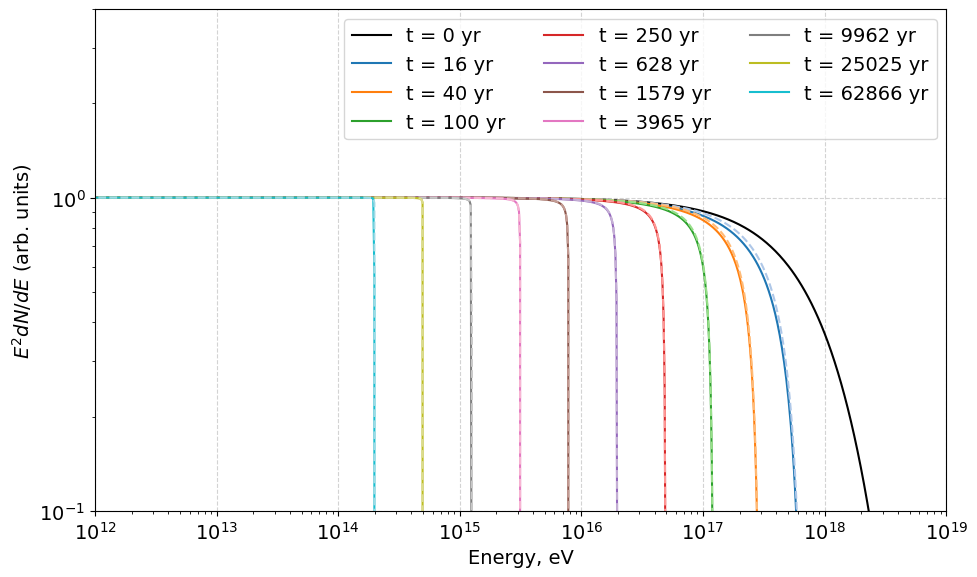

In [13]:
plt.figure(figsize=(10, 6))
plt.loglog(energies, energies**2 * spectrum(energies.value), color='black', label=f"t = 0 yr")

counter = 0
for i, t_i in enumerate(times):
    if (i + 200) % 800 == 0 and t_i > 10 * u.year:
        # numerical solution
        plt.loglog(energies, energies**2 * spectrum(energy_sol[:, i]) * exponent[:, i], label=f't = {t_i:.0f}',
                   color=colors[2 * counter])
        # analytical solution
        sharp = sharp_1Gauss * (B0.value / 1e-6)**2
        e_good = sharp * energies * t_i < 1
        analyt = spectrum((energies / (1 - sharp * energies * t_i)).value) / (1 - sharp * energies * t_i)**2
        plt.plot(energies, energies**2 * analyt * e_good, linestyle='dashed', color=colors[2 * counter + 1])
        counter = (counter + 1) % cmap.N


plt.xlim(1e12, 1e19)
# plt.ylim(1e-40, 1e-20)
plt.ylim(1e-1, 4)
plt.xlabel('Energy, eV')
plt.ylabel(r'$E^2 dN/dE$ (arb. units)')
plt.legend(ncol=3)

plt.tight_layout()
# plt.savefig('pictures/synchrotron_losses_evolution.png', dpi=600)
# plt.savefig('pictures/synchrotron_losses_evolution.pdf')
plt.show()

# Synchrotron & Inverse Compton losses: estimation of importance?

In [14]:
"""from src.electron_timescales import inverse_compton_timescale

e2 = np.logspace(9, 19, 1000) * u.eV
ic_time = inverse_compton_timescale(e2, cst.m_e)

import os
import pickle
from config.settings import ELECTRONS_DIR
pickle.dump([e2, ic_time], open(os.path.join(ELECTRONS_DIR, "ic_time.pck"), "wb"))"""

'from src.electron_timescales import inverse_compton_timescale\n\ne2 = np.logspace(9, 19, 1000) * u.eV\nic_time = inverse_compton_timescale(e2, cst.m_e)\n\nimport os\nimport pickle\nfrom config.settings import ELECTRONS_DIR\npickle.dump([e2, ic_time], open(os.path.join(ELECTRONS_DIR, "ic_time.pck"), "wb"))'

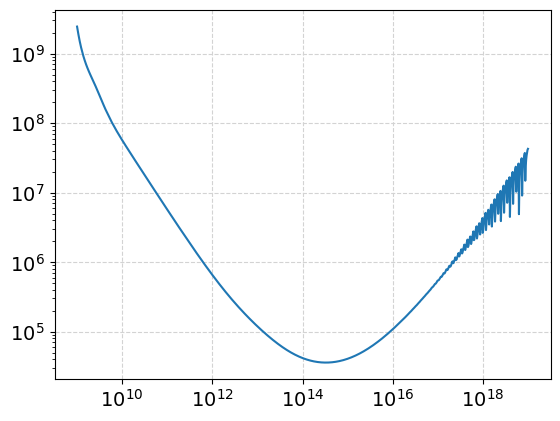

In [15]:
import pickle
data = pickle.load(open(os.path.join(ELECTRONS_DIR, "ic_time.pck"), "rb"))

energies, ic_time = data[0], data[1]
plt.loglog(energies, ic_time)

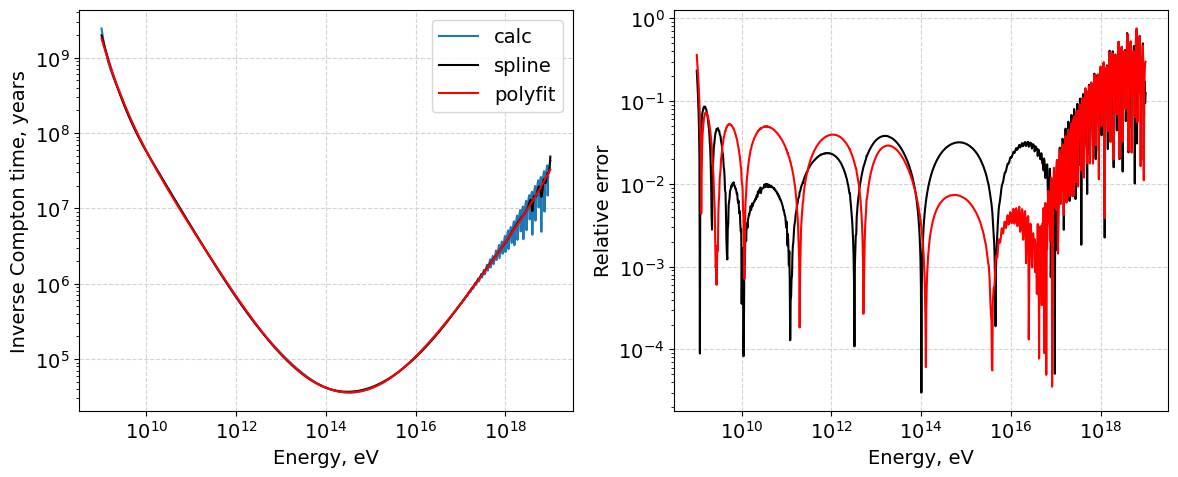

In [16]:
from scipy.interpolate import make_splrep

ic_time_f = make_splrep(np.log10(energies.value), np.log10(ic_time.value), k=3, s=2)
ic_time_2 = np.polyfit(np.log10(energies.value), np.log10(ic_time.value), 6)
ic_time_f2 = np.poly1d(ic_time_2)

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.loglog(energies, ic_time, label='calc')
splined = 10**ic_time_f(np.log10(energies.value))
pftd = 10**ic_time_f2(np.log10(energies.value))
plt.loglog(energies, splined, color='black', label='spline')
plt.loglog(energies, pftd, color='red', label='polyfit')
plt.loglog()
plt.legend()

plt.xlabel('Energy, eV')
plt.ylabel('Inverse Compton time, years')

plt.subplot(122)
plt.loglog(energies, abs(ic_time.value - splined) / splined, color='black')
plt.loglog(energies, abs(ic_time.value - pftd) / pftd, color='red')
plt.xlabel('Energy, eV')
plt.ylabel('Relative error')

plt.tight_layout()
plt.show()

In [17]:
def compton_losses(time_value, energy_value):
    energy_value = np.clip(energy_value, a_min=1e9, a_max=1e19)
    return energy_value / 10**ic_time_f(np.log10(energy_value))

In [18]:
def total_losses(time_value, energy_value, bf_value):
    return synchrotron_losses(time_value, energy_value, bf_value) + compton_losses(time_value, energy_value)

Use log-log derivative here!

$$ \dfrac{d\lg f}{d\lg x} = \dfrac{x}{f}\dfrac{df}{dx} $$

In [19]:
from scipy.differentiate import derivative
def lg_total_losses_time_independent(lg_energy_value, bf_value):
    return np.log10(total_losses(0.0, 10**lg_energy_value, bf_value))

def total_losses_derivative(time_value, energy_value, bf_value):
    energy_value = np.clip(energy_value, a_min=1e-10, a_max=1e29)
    lg_energy_value = np.log10(energy_value)
    total_losses_value = total_losses(time_value, energy_value, bf_value)
    return -total_losses_value / energy_value * derivative(lg_total_losses_time_independent, lg_energy_value, args=(bf_value,)).df

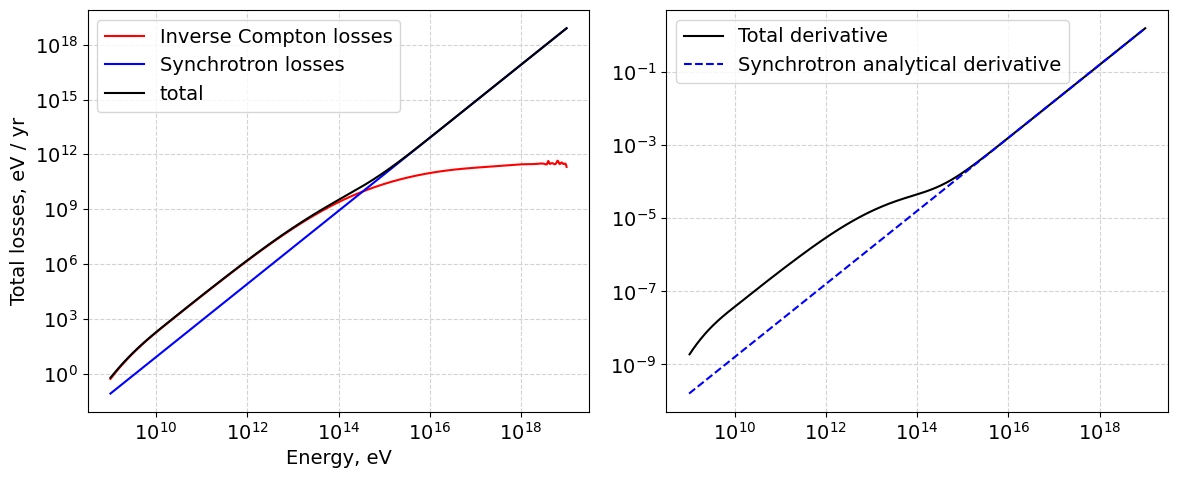

In [20]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.loglog(energies, compton_losses(0, energies.value), color='red', label=f"Inverse Compton losses")
plt.loglog(energies, synchrotron_losses(0, energies.value, B0.value), color='blue', label=f"Synchrotron losses")

plt.loglog(energies, total_losses(0, energies.value, B0.value), color='black', label=f"total")

plt.xlabel('Energy, eV')
plt.ylabel('Total losses, eV / yr')
plt.legend()

plt.subplot(122)

plt.plot(energies[1:], -total_losses_derivative(0, energies.value[1:], B0.value),
         color='black', label="Total derivative")
plt.plot(energies, -synchrotron_losses_energy_derivative(0, energies.value, B0.value),
         color='blue', label='Synchrotron analytical derivative', linestyle='dashed')
plt.xscale('log')
plt.yscale('log')
plt.legend()

plt.tight_layout()
plt.show()

Finally, the calculation!

Step 1. Energy backpropagation

In [21]:
# time grid
dt = synchrotron_timescale(10000 * u.PeV, B0, cst.m_e)  # unit-time
print(f"time scale = {dt:.0f}")

M = 10000
times = np.logspace(0, 5, M) * dt
print(f"time_max = {times[-1]:.0f}")

time scale = 1 yr
time_max = 125298 yr


In [22]:
# energy grid
N = 1000
energies = np.logspace(10, 19, N) * u.eV
print(f"min_energy {energies[0]:.0g}, max_energy {energies[-1]:.0g}")

min_energy 1e+10 eV, max_energy 1e+19 eV


In [23]:
sol = solve_ivp(total_losses, t_span=(0, times[-1].value), y0=energies.value, args=(B0.value,),
                t_eval=times.value, method='RK45', dense_output=True)
print(sol.success)

True


Step 2. Spectrum calculation

In [24]:
time_sol = sol.t
energy_sol = sol.y

In [25]:
loss_derivative = total_losses_derivative(time_sol, energy_sol, B0.value)
loss_derivative_integral = np.clip(cumulative_trapezoid(loss_derivative, time_sol, initial=0), a_min=-10, a_max=10)
exponent = np.exp(-loss_derivative_integral)

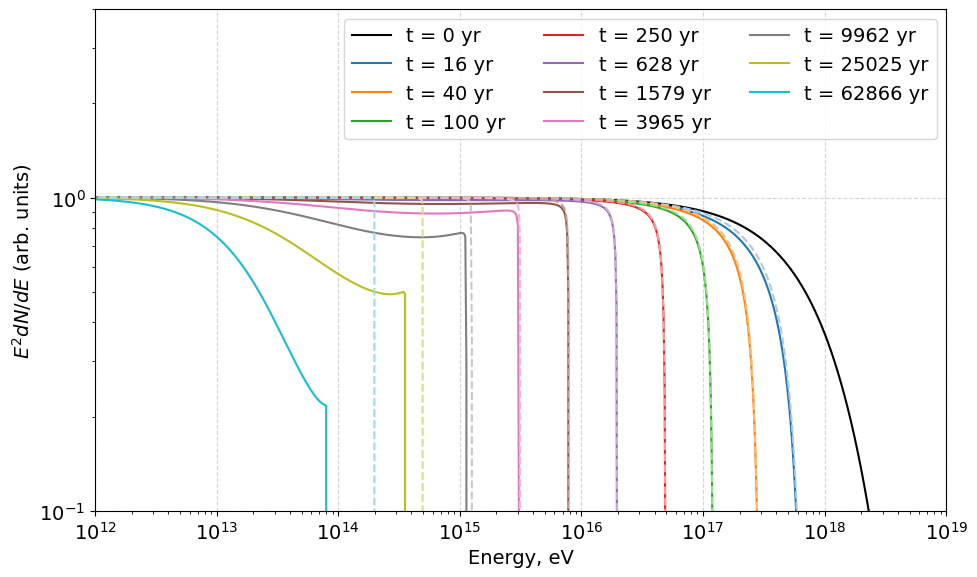

In [26]:
def current_spectrum(E):
    return spectrum(E, Gamma=2.0, E_cut=1e18)

plt.figure(figsize=(10, 6))
plt.loglog(energies, energies**2 * current_spectrum(energies.value), color='black', label=f"t = 0 yr")

counter = 0
for i, t_i in enumerate(times):
    if (i + 200) % 800 == 0 and t_i > 10 * u.year:
        # numerical solution
        plt.loglog(energies, energies**2 * current_spectrum(energy_sol[:, i]) * exponent[:, i], label=f't = {t_i:.0f}',
                   color=colors[2 * counter])
        # analytical solution
        sharp = sharp_1Gauss * (B0.value / 1e-6)**2
        e_good = sharp * energies * t_i < 1
        analyt = current_spectrum((energies / (1 - sharp * energies * t_i)).value) / (1 - sharp * energies * t_i)**2
        plt.plot(energies, energies**2 * analyt * e_good, linestyle='dashed', color=colors[2 * counter + 1])
        counter = (counter + 1) % cmap.N


# plt.plot(energies, (energies / 1e12)**2 * (energies.value / 1e12)**(-2.0) * np.exp(-(energies.value / 1e15)), linewidth=5)


plt.xlim(1e12, 1e19)
# plt.ylim(1e-40, 1e-20)
plt.ylim(1e-1, 4)
plt.xlabel('Energy, eV')
plt.ylabel(r'$E^2 dN/dE$ (arb. units)')
plt.legend(ncol=3)

plt.tight_layout()
plt.show()
